In [5]:
import os
from glob import glob
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from random import randint

## 1. Data Processing

In [6]:
dataset_root_folder = 'data'
image_list = glob('data/Tile */images')
masks_list = glob('data/Tile */masks')

In [7]:
# The idea is that the width and height of the all the images should be multiples of that of the others
# for this purpose, a base patch size is defined, which is used to crop the images using a formula 
# to determine the new shape
# new_width = (image.shape[1] // image_patch_size) * image_patch_size
# new_height = (image.shape[0] // image_patch_size) * image_patch_size
image_patch_size = 256


In [8]:
def create_dataset_patches(input_dataset_folders_list=[], patch_size=256, cv2_color_transform=None, apply_mix_max_scaler=False):
  output_dataset_list = []
  minmaxscaler = MinMaxScaler()
  for path in input_dataset_folders_list:
    for file in os.listdir(path):
      image = cv2.imread(os.path.join(path, file))
      if image is not None:
        if cv2_color_transform:
          # this is applied only to the masks
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(image.shape)
        width = (image.shape[1] // patch_size) * patch_size
        height = (image.shape[0] // patch_size) * patch_size
        # print(f'{image.shape} --- {width} - {height}')
        image = Image.fromarray(image) # convert to Image object
        image = image.crop((0, 0, width, height)) # Box (left, upper, right, lower)
        # print(f'({image.size[0]}, {image.size[1]})')
        image = np.array(image) # convert back to numpy array
        # create image patches of shape (patch_size, patch_size, 3)
        patched_images = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        patched_shape = patched_images.shape
        for i in range(patched_shape[0]):
          for j in range(patched_shape[1]):
            individual_patched_image = patched_images[i, j, :, :]
            if apply_mix_max_scaler:
              # (1, width, height, num_bands)
              individual_patch_size = individual_patched_image.shape
              # print(individual_patch_size)
              # (width, height, num_bands)
              individual_patched_image = minmaxscaler.fit_transform(
                individual_patched_image.reshape(-1, individual_patch_size[-1])
              ).reshape(individual_patch_size)
            individual_patched_image = individual_patched_image[0]
            # print(individual_patched_image.shape)
            output_dataset_list.append(individual_patched_image)
  return output_dataset_list



In [9]:
image_dataset = create_dataset_patches(image_list, image_patch_size, apply_mix_max_scaler=True)
mask_dataset = create_dataset_patches(masks_list, image_patch_size, cv2.COLOR_BGR2RGB)

In [6]:
print(len(image_dataset))
print(len(mask_dataset))

1305
1305


In [10]:
mask_dataset[0].shape

(256, 256, 3)

In [11]:
# convert each dataset list into single numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

print(len(image_dataset))
print(len(mask_dataset))

1305
1305


In [12]:
def plot_image_and_mask(images_dataset, masks_dataset, index=0):
  print(f'Printing image and mask at index: {index}')
  plt.figure(figsize=(12, 8))
  plt.subplot(121)
  plt.imshow(images_dataset[index])
  plt.subplot(122)
  plt.imshow(masks_dataset[index])

Printing image and mask at index: 407


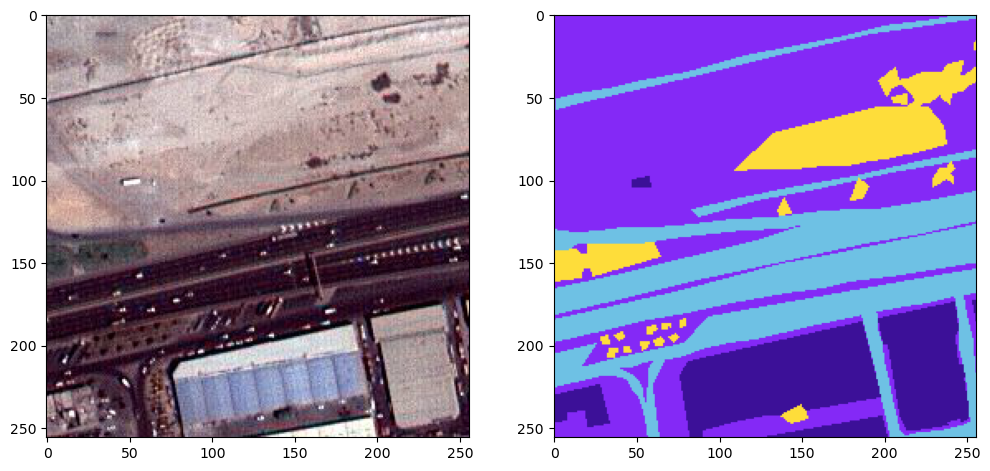

In [87]:
max_range = min(len(image_dataset), len(mask_dataset))
random_index = randint(0, max_range)
plot_image_and_mask(image_dataset, mask_dataset, random_index)

### Processing Mask Image Labels

In [13]:
def hex_to_rgb(hex_string='000000'):
  hex_string = hex_string.lstrip('#')
  return tuple(int(hex_string[i: i + 2], 16) for i in (0, 2, 4))

def class_to_rgb(class_name, hex_string, value=0):
  rgb_tuple = hex_to_rgb(hex_string)
  return {'class': class_name, 'color': np.array(rgb_tuple), 'value': value}

def rgb_to_label(mask, rgb_classes):
  label_segment = np.zeros_like(mask, dtype=np.uint8)
  for cl in rgb_classes:
    label_segment[np.all(mask == cl['color'], axis=-1)] = cl['value']
  label_segment = label_segment[:, :, 0]
  return label_segment

In [14]:
classes = [
  {'class': 'Building', 'color': '#3C1098','value': 3},
  {'class': 'Land', 'color': '#8429F6', 'value': 1},
  {'class': 'Road', 'color': '#6EC1E4', 'value': 2},
  {'class': 'Vegetation', 'color': '#FEDD3A', 'value': 4},
  {'class': 'Water', 'color': '#E2A929', 'value': 0},
  {'class': 'Unlabeled', 'color': '#9B9B9B', 'value': 5}
]

classes_rgb = list(map(lambda cl: class_to_rgb(cl['class'], cl['color'], cl['value']), classes))

In [15]:
labels = []

for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i], classes_rgb)
  labels.append(label)


In [13]:
len(labels)

1305

In [16]:
labels = np.expand_dims(labels, axis=3)

In [17]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

Printing image and mask at index: 216


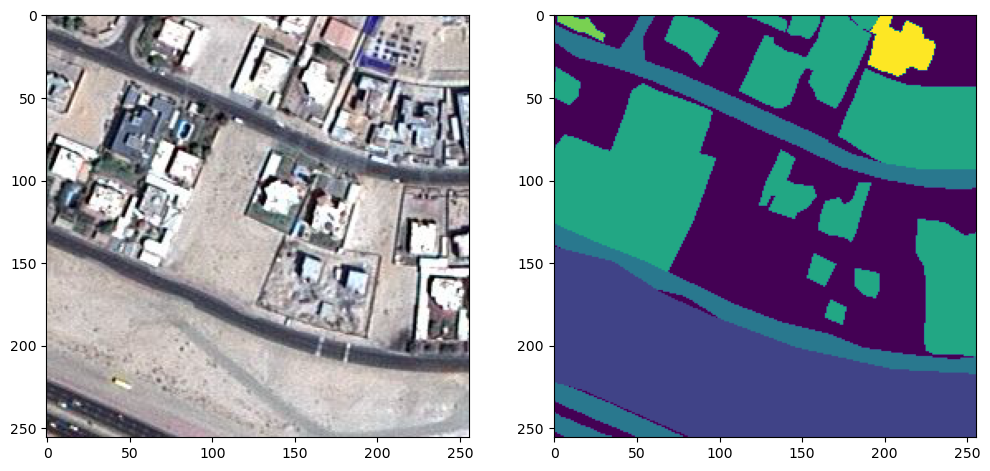

In [92]:
sliced_labels = list(map(lambda ds: ds[:, :, 0], labels))
max_range = min(len(image_dataset), len(sliced_labels))
random_index = randint(0, max_range)
plot_image_and_mask(image_dataset, sliced_labels, random_index)

## 2. Training and Prediction

### Create Test and Training Dataset

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K

2023-01-24 22:19:58.164436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
master_training_dataset = mask_dataset
total_classes = len(np.unique(labels))
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [20]:
labels_categorical_dataset.shape

(1305, 256, 256, 6)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, random_state=102)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(978, 256, 256, 3)
(327, 256, 256, 3)
(978, 256, 256, 6)
(327, 256, 256, 6)


In [23]:
image_width = X_train.shape[1]
image_height = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [24]:
# create function to estimate the Jaccard Index
# this index is a measurement used in deep learning to evaluate how a detected object
# overlaps with its real-world counter part
# the closer the index to 100% the better
def calculate_jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = intersection / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [25]:
def multi_unet_model(n_classes=5, input_image_height=256, input_image_width=256, n_image_channels=1):
  inputs = Input((input_image_height, input_image_width, n_image_channels))
  source_input = inputs

  c1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(source_input)
  c1 = Dropout(rate=0.2)(c1)
  c1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(rate=0.2)(c2)
  c2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(rate=0.2)(c3)
  c3 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(rate=0.2)(c4)
  c4 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D((2, 2))(c4)

  c5 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(rate=0.2)(c5)
  c5 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  u6 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(rate=0.2)(c6)
  c6 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(rate=0.2)(c7)
  c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(rate=0.2)(c8)
  c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(rate=0.2)(c9)
  c9 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [26]:
metrics = ['accuracy', calculate_jaccard_coef]

In [27]:
def get_deep_learning_model():
  return multi_unet_model(
    n_classes=total_classes,
    input_image_width=image_width,
    input_image_height=image_height,
    n_image_channels=image_channels
  )

In [28]:
model = get_deep_learning_model()

2023-01-24 22:20:33.677221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# model.get_config()

### Generate Loss Function

In [30]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
print(os.environ.get('SM_FRAMEWORK'))

tf.keras


In [31]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [32]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

In [40]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

### Model Compilation

In [34]:
import tensorflow as tf

In [35]:
tf.keras.backend.clear_session()

In [41]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [42]:
model_history = model.fit(X_train, y_train,
  batch_size=16,
  verbose=1,
  epochs=10,
  validation_data=(X_test, y_test),
  shuffle=False)

Epoch 1/10
62/62 [==============================] - 231s 4s/step - loss: 1.3227 - accuracy: 0.4901 - calculate_jaccard_coef: 0.3326 - val_loss: 1.3013 - val_accuracy: 0.5205 - val_calculate_jaccard_coef: 0.3539
Epoch 2/10
62/62 [==============================] - 229s 4s/step - loss: 1.2917 - accuracy: 0.5370 - calculate_jaccard_coef: 0.3691 - val_loss: 1.3013 - val_accuracy: 0.5205 - val_calculate_jaccard_coef: 0.3539
Epoch 3/10
62/62 [==============================] - 227s 4s/step - loss: 1.2917 - accuracy: 0.5370 - calculate_jaccard_coef: 0.3691 - val_loss: 1.3013 - val_accuracy: 0.5205 - val_calculate_jaccard_coef: 0.3539
Epoch 4/10
62/62 [==============================] - 224s 4s/step - loss: 1.2912 - accuracy: 0.5370 - calculate_jaccard_coef: 0.3691 - val_loss: 1.3013 - val_accuracy: 0.5205 - val_calculate_jaccard_coef: 0.3539
Epoch 5/10
62/62 [==============================] - 226s 4s/step - loss: 1.2917 - accuracy: 0.5370 - calculate_jaccard_coef: 0.3691 - val_loss: 1.3013 - val

In [46]:
model_history.history['calculate_jaccard_coef']

[0.3325587809085846,
 0.369086354970932,
 0.36908793449401855,
 0.3690900504589081,
 0.369091659784317,
 0.36909177899360657,
 0.3690922260284424,
 0.36909353733062744,
 0.369093656539917,
 0.3690941035747528]

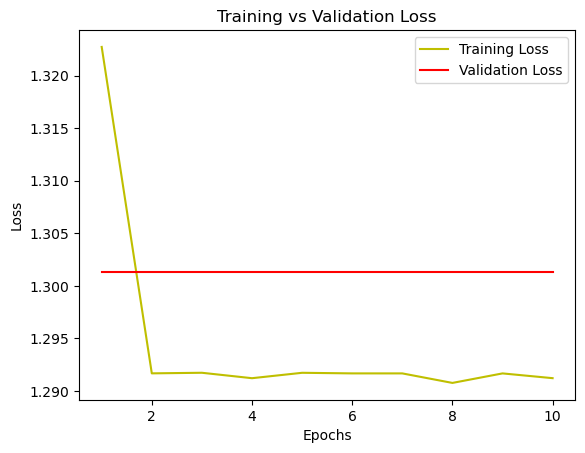

In [48]:
history = model_history.history
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

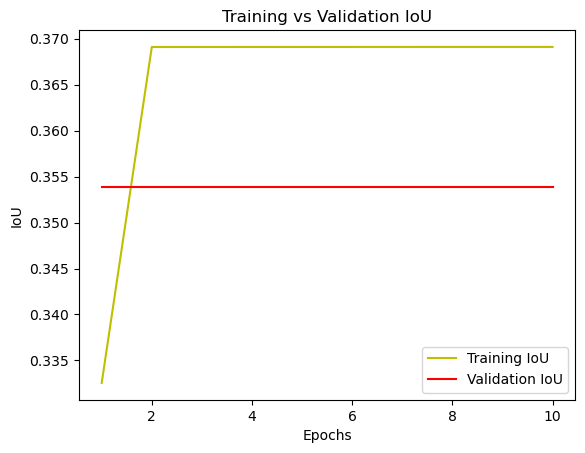

In [49]:
jaccard_coef = history['calculate_jaccard_coef']
val_jaccard_coef = history['val_calculate_jaccard_coef']
plt.plot(epochs, jaccard_coef, 'y', label='Training IoU')
plt.plot(epochs, val_jaccard_coef, 'r', label='Validation IoU')
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Testing Predictions

In [50]:
y_pred = model.predict(X_test)

11/11 [==============================] - 12s 1s/step


In [51]:
len(y_pred)

327

In [52]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [55]:
len(y_pred_argmax)

327

In [56]:
y_test_argmax = np.argmax(y_test, axis=3)

In [57]:
len(y_test_argmax)

327

In [65]:
image_index = 10
test_image = X_test[image_index]
true_image = y_test_argmax[image_index]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0, :, :]


1/1 [==============================] - 0s 89ms/step


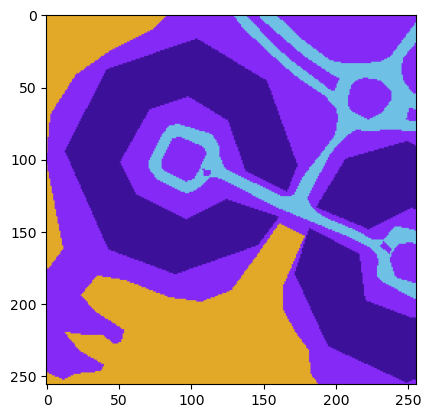

In [70]:
plt.imshow(test_image)

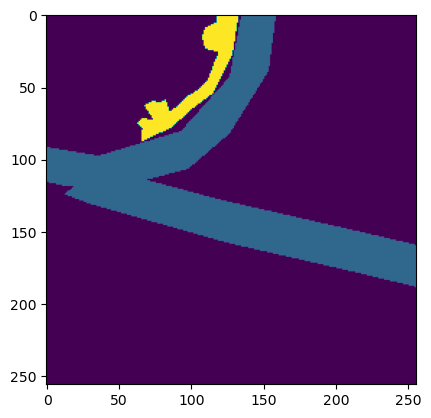

In [71]:
plt.imshow(true_image)

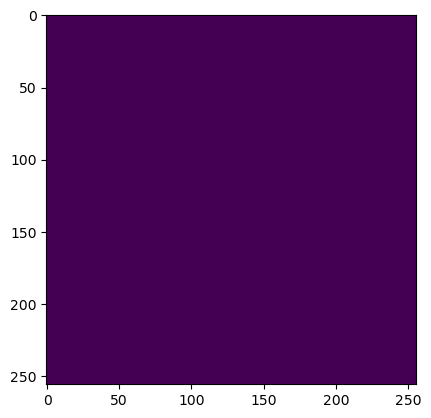

In [72]:
plt.imshow(predicted_image)